## Download de pacotes necessários

In [2]:
!pip install stable-baselines3[extra] sb3_contrib pybullet numpngw 

     |████████████████████████████████| 174 kB 4.8 MB/s eta 0:00:01
     |████████████████████████████████| 45 kB 7.3 MB/s  eta 0:00:01
     |████████████████████████████████| 89.3 MB 54.3 MB/s eta 0:00:011     |██████████████████▎             | 51.0 MB 109.9 MB/s eta 0:00:01     |█████████████████████▉          | 60.8 MB 109.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 60.7 MB/s eta 0:00:01
     |████████████████████████████████| 881.9 MB 5.7 kB/s  eta 0:00:01    |██▉                             | 77.7 MB 23.7 MB/s eta 0:00:34     |████                            | 110.2 MB 13.6 MB/s eta 0:00:57     |████████████                    | 329.8 MB 14.0 MB/s eta 0:00:40███▋        | 650.2 MB 20.2 MB/s eta 0:00:12     |█████████████████████████▉      | 712.1 MB 28.1 MB/s eta 0:00:07     |███████████████████████████     | 742.2 MB 21.9 MB/s eta 0:00:07��████████████| 879.4 MB 39.1 MB/s eta 0:00:01
     |████████████████████████████████| 5.8 MB 58.9 MB/s eta 0:00:01
     |

In [1]:
import os, pybullet_envs

import numpy as np

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize
from stable_baselines3.common.utils import constant_fn

from sb3_contrib.common.wrappers import TimeFeatureWrapper

from torch.nn import ReLU

from results_plotter import plot_results, X_TIMESTEPS

from callback import SaveOnBestTrainingRewardCallback
from utils import load_eval_env, read_yaml, eval2gif, get_experiments_animations

## Configurações de ambiente

- No caso do nosso experimento usaremos uma seed fixa
    - É interessante rodar os experimentos em mais de uma seed para garantir o desempenho dos algoritmos de DRL
- O treino do agente vai exigir 2 milhões de timesteps

In [2]:
# seed = np.random.randint(low=0, high=2**32 - 1)
seed = 2115376553
log_dir = os.path.join("log_dir", str(seed))
total_timesteps = 2e6

- Utilizaremos o ambiente de simulação AntBulletEnv-v0, o qual simula um agente robótico de quatro patas, similar a uma formiga.
- Você pode ajustar a quantidade de ambientes que vamos rodar em paralelo durante o treino mudando n_envs

In [3]:
env_id = "AntBulletEnv-v0"

In [4]:
env = make_vec_env(env_id=env_id,
                   seed=seed,
                   n_envs=os.cpu_count(),
                   monitor_dir=log_dir,
                   wrapper_class=TimeFeatureWrapper)

env = VecNormalize(env, norm_obs=True, norm_reward=True)

pybullet build time: Oct 11 2021 20:59:39
/home/rogers/.local/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## Treinamento

- A função callback SaveOnBestTrainingRewardCallback verifica mudanças nas recompensas obtidas a cada 20 mil timesteps
    - Também realiza o salvamento das melhores políticas

In [5]:
callback = SaveOnBestTrainingRewardCallback(check_freq=20000, total_timesteps=total_timesteps, log_dir=log_dir)

- Como mencionado na apresentação, utilizaremos o Proximal Policy Optmization para treinar nosso agente
- Os parâmetros foram copiados do benchmark RL-Zoo: https://github.com/DLR-RM/rl-baselines3-zoo/blob/master/hyperparams/ppo.yml
- O PPO tem baixa sensibilidade a mudança de parâmetros

In [6]:
model = PPO('MlpPolicy', 
        env,
        policy_kwargs=dict(log_std_init=-1,
                           ortho_init=False,
                           activation_fn=ReLU,
                           net_arch=[dict(pi=[256, 256], vf=[256, 256])]),
        batch_size=128,
        n_steps=512,
        gamma=0.99,
        gae_lambda=0.9,
        n_epochs=20,
        ent_coef=0.0,
        sde_sample_freq=4,
        max_grad_norm=0.5,
        vf_coef=0.5,
        learning_rate=constant_fn(3e-5),
        use_sde=True,
        clip_range=constant_fn(0.4),
        device="cuda", 
        seed=seed,
        verbose=0)

model.learn(total_timesteps=total_timesteps, callback=callback)


        》》》》》 SEED 🎲 2115376553
        》》》》》 Timesteps 🏃 2007040/2000000.0
        》》》》》 Best reward 🥇 2755.83 ± 103.49
        


- Salvamento do modelo e do ambiente para avaliação futura

In [7]:
model.save(os.path.join(log_dir, "final_model"))
env.save(os.path.join(log_dir, "vec_normalize.pkl"))

### Testes

In [8]:
# Retire os comentários para definir as variáveis abaixo
# log_dir = 'log_dir/3686580095'
# seed = 3686580095
# env_id = "AntBulletEnv-v0"

- Carregamos os metadados das melhores políticas obtidas durante o treinamento
- O ambiente utilizado no treinamento tambm é carregado, com o n_envs=1

In [9]:
best_models = read_yaml(os.path.join(log_dir, "best_models", "metadata.yml"))

In [10]:
eval_env = load_eval_env(stats_path=os.path.join(log_dir, "vec_normalize.pkl"), 
                         env_id=env_id, 
                         seed=seed, 
                         n_envs=1, 
                         wrapper_class=TimeFeatureWrapper)

- Na sequência, geramos os GIFs para cada política salva durante o treino
- Os GIFs são então convertidos em uma pequena página html, para uma melhor visualização

In [11]:
eval2gif(best_models, eval_env, PPO, log_dir)

argv[0]=
argv[0]=


In [12]:
gifs_metadata = os.path.join(log_dir, "result_animations", "metadata.yml")

In [13]:
animations = get_experiments_animations(gifs_metadata)

In [14]:
with open(os.path.join(log_dir, "result_animations", "result.html"), "w") as html_file:
    html_file.write(animations)

### Resultados em gráfico

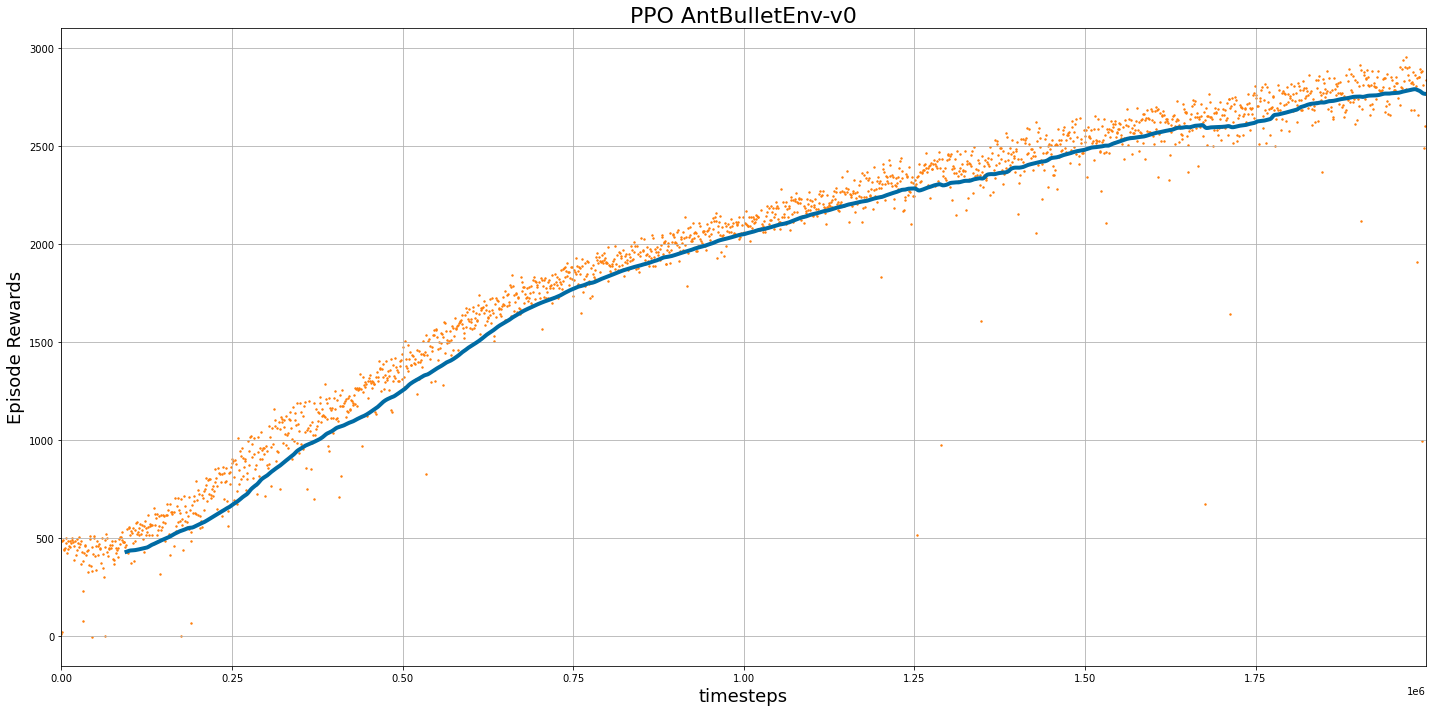

In [15]:
plot_results([log_dir], int(2e6), X_TIMESTEPS, "PPO AntBulletEnv-v0", (20, 10))